In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from sklearn.externals import joblib
%matplotlib inline
import seaborn as sns

DIR = '~/Desktop'

In [12]:
X = pd.read_csv(os.path.join(DIR,'application_train.csv'), nrows=None)

X.head()

SyntaxError: EOL while scanning string literal (<ipython-input-12-5d9c5caf188e>, line 2)

# Preprocessing
## Solution 3

[Martin Kotek (Competition Host): "Value 365243 denotes infinity in DAYS variables in the datasets, therefore you can consider them NA values. Also XNA/XAP denote NA values."](https://www.kaggle.com/c/home-credit-default-risk/discussion/57247)

In [4]:
X['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [5]:
X.loc[X['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

In [6]:
sum(X['ORGANIZATION_TYPE'] == 'XNA')

55374

In [7]:
X['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [8]:
X['CODE_GENDER'].replace('XNA',np.nan, inplace=True)
X['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

## Solution 5

In [9]:
X['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

# Feature Engineering
## Solution 3
### Hand crafted features

In [ ]:
# 年金を収入で割る
X['annuity_income_percentage'] = X['AMT_ANNUITY'] / X['AMT_INCOME_TOTAL']
# 保持している車の年齢を、生まれてからの日にちでわる
X['car_to_birth_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_BIRTH']
# 雇用日数で、車の年齢でわる
X['car_to_employ_ratio'] = X['OWN_CAR_AGE'] / X['DAYS_EMPLOYED']
# 家族内でのこどもの比率
X['children_ratio'] = X['CNT_CHILDREN'] / X['CNT_FAM_MEMBERS']
# 預金と年金を割る
X['credit_to_annuity_ratio'] = X['AMT_CREDIT'] / X['AMT_ANNUITY']
# 預金を賞品のローんで割る
X['credit_to_goods_ratio'] = X['AMT_CREDIT'] / X['AMT_GOODS_PRICE']
# 総収入を預金で割る
X['credit_to_income_ratio'] = X['AMT_CREDIT'] / X['AMT_INCOME_TOTAL']
# 生まれてからの日を雇用日数でわえう
X['days_employed_percentage'] = X['DAYS_EMPLOYED'] / X['DAYS_BIRTH']
# 預金を収入で割る
X['income_credit_percentage'] = X['AMT_INCOME_TOTAL'] / X['AMT_CREDIT']
# こども一人に対する収入の割合
X['income_per_child'] = X['AMT_INCOME_TOTAL'] / (1 + X['CNT_CHILDREN'])
# 一人あたりに対する総収入（家族）
X['income_per_person'] = X['AMT_INCOME_TOTAL'] / X['CNT_FAM_MEMBERS']
# 年金を預金で割る
X['payment_rate'] = X['AMT_ANNUITY'] / X['AMT_CREDIT']
# 生まれた日から最後に携帯を変えた日で割る
X['phone_to_birth_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_BIRTH']
# 雇用日数で最後に携帯を変えた日で割る
X['phone_to_employ_ratio'] = X['DAYS_LAST_PHONE_CHANGE'] / X['DAYS_EMPLOYED']

? どのように重みづけをしているのか

In [10]:
# External sources
X['external_sources_weighted'] = X.EXT_SOURCE_1 * 2 + X.EXT_SOURCE_2 * 3 + X.EXT_SOURCE_3 * 4
for function_name in ['min', 'max', 'sum', 'mean', 'nanmedian']:
    X['external_sources_{}'.format(function_name)] = eval('np.{}'.format(function_name))(
        X[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

/Users/akihiro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [15]:
engineered_numerical_columns = ['annuity_income_percentage',
                                'car_to_birth_ratio',
                                'car_to_employ_ratio',
                                'children_ratio',
                                'credit_to_annuity_ratio',
                                'credit_to_goods_ratio',
                                'credit_to_income_ratio',
                                'days_employed_percentage',
                                'income_credit_percentage',
                                'income_per_child',
                                'income_per_person',
                                'payment_rate',
                                'phone_to_birth_ratio',
                                'phone_to_employ_ratio',
                                'external_sources_weighted',
                                'external_sources_min',
                                'external_sources_max',
                                'external_sources_sum',
                                'external_sources_mean',
                                'external_sources_nanmedian']

In [18]:
X_eng = X[engineered_numerical_columns + ['TARGET']]
X_eng_corr = abs(X_eng.corr())

In [19]:
X_eng_corr.sort_values('TARGET', ascending=False)['TARGET']

TARGET                        1.000000
external_sources_weighted     0.236289
external_sources_mean         0.222052
external_sources_nanmedian    0.218118
external_sources_max          0.196876
external_sources_min          0.185266
external_sources_sum          0.173322
credit_to_goods_ratio         0.069427
car_to_birth_ratio            0.048824
days_employed_percentage      0.042206
credit_to_annuity_ratio       0.032102
car_to_employ_ratio           0.030553
phone_to_birth_ratio          0.029550
children_ratio                0.021223
annuity_income_percentage     0.014265
payment_rate                  0.012704
income_per_child              0.012529
credit_to_income_ratio        0.007727
phone_to_employ_ratio         0.006714
income_per_person             0.006571
income_credit_percentage      0.001817
Name: TARGET, dtype: float64

In [26]:
X_eng_corr.columns

Index(['annuity_income_percentage', 'car_to_birth_ratio',
       'car_to_employ_ratio', 'children_ratio', 'credit_to_annuity_ratio',
       'credit_to_goods_ratio', 'credit_to_income_ratio',
       'days_employed_percentage', 'income_credit_percentage',
       'income_per_child', 'income_per_person', 'payment_rate',
       'phone_to_birth_ratio', 'phone_to_employ_ratio',
       'external_sources_weighted', 'external_sources_min',
       'external_sources_max', 'external_sources_sum', 'external_sources_mean',
       'external_sources_nanmedian', 'TARGET'],
      dtype='object')

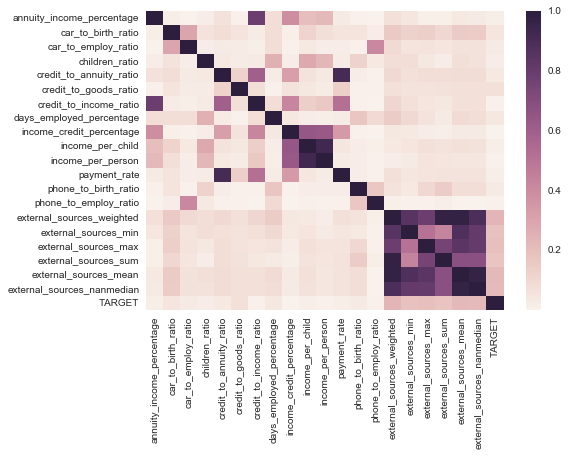

In [27]:
sns.heatmap(X_eng_corr)

### Aggregation features

In [28]:
AGGREGATION_RECIPIES = [
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE'], [('AMT_ANNUITY', 'max'),
                                              ('AMT_CREDIT', 'max'),
                                              ('EXT_SOURCE_1', 'mean'),
                                              ('EXT_SOURCE_2', 'mean'),
                                              ('OWN_CAR_AGE', 'max'),
                                              ('OWN_CAR_AGE', 'sum')]),
    (['CODE_GENDER', 'ORGANIZATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                                            ('AMT_INCOME_TOTAL', 'mean'),
                                            ('DAYS_REGISTRATION', 'mean'),
                                            ('EXT_SOURCE_1', 'mean')]),
    (['CODE_GENDER', 'REG_CITY_NOT_WORK_CITY'], [('AMT_ANNUITY', 'mean'),
                                                 ('CNT_CHILDREN', 'mean'),
                                                 ('DAYS_ID_PUBLISH', 'mean')]),
    (['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('EXT_SOURCE_1', 'mean'),
                                                                                           ('EXT_SOURCE_2', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE'], [('AMT_CREDIT', 'mean'),
                                                  ('AMT_REQ_CREDIT_BUREAU_YEAR', 'mean'),
                                                  ('APARTMENTS_AVG', 'mean'),
                                                  ('BASEMENTAREA_AVG', 'mean'),
                                                  ('EXT_SOURCE_1', 'mean'),
                                                  ('EXT_SOURCE_2', 'mean'),
                                                  ('EXT_SOURCE_3', 'mean'),
                                                  ('NONLIVINGAREA_AVG', 'mean'),
                                                  ('OWN_CAR_AGE', 'mean'),
                                                  ('YEARS_BUILD_AVG', 'mean')]),
    (['NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY'], [('ELEVATORS_AVG', 'mean'),
                                                                            ('EXT_SOURCE_1', 'mean')]),
    (['OCCUPATION_TYPE'], [('AMT_ANNUITY', 'mean'),
                           ('CNT_CHILDREN', 'mean'),
                           ('CNT_FAM_MEMBERS', 'mean'),
                           ('DAYS_BIRTH', 'mean'),
                           ('DAYS_EMPLOYED', 'mean'),
                           ('DAYS_ID_PUBLISH', 'mean'),
                           ('DAYS_REGISTRATION', 'mean'),
                           ('EXT_SOURCE_1', 'mean'),
                           ('EXT_SOURCE_2', 'mean'),
                           ('EXT_SOURCE_3', 'mean')]),
]

学歴と性別で、グループ化する（女性で、大卒みたいな）　 そのグループ内でのMAX値を値とする。 -> 学歴と性別で、グループ化し、それぞれのグループの年金の最大値をカラムとする


In [31]:
AGGREGATION_RECIPIES[0]

(['CODE_GENDER', 'NAME_EDUCATION_TYPE'],
 [('AMT_ANNUITY', 'max'),
  ('AMT_CREDIT', 'max'),
  ('EXT_SOURCE_1', 'mean'),
  ('EXT_SOURCE_2', 'mean'),
  ('OWN_CAR_AGE', 'max'),
  ('OWN_CAR_AGE', 'sum')])

In [40]:
groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = X.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        X = X.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)


In [41]:
X_agg = X[groupby_aggregate_names + ['TARGET']]
X_agg_corr = abs(X_agg.corr())

KeyError: "['CODE_GENDER_NAME_EDUCATION_TYPE_max_AMT_CREDIT'\n 'CODE_GENDER_NAME_EDUCATION_TYPE_mean_EXT_SOURCE_1'\n 'CODE_GENDER_NAME_EDUCATION_TYPE_mean_EXT_SOURCE_2'\n 'CODE_GENDER_NAME_EDUCATION_TYPE_max_OWN_CAR_AGE'\n 'CODE_GENDER_NAME_EDUCATION_TYPE_sum_OWN_CAR_AGE'\n 'CODE_GENDER_ORGANIZATION_TYPE_mean_AMT_ANNUITY'\n 'CODE_GENDER_ORGANIZATION_TYPE_mean_AMT_INCOME_TOTAL'\n 'CODE_GENDER_ORGANIZATION_TYPE_mean_DAYS_REGISTRATION'\n 'CODE_GENDER_ORGANIZATION_TYPE_mean_EXT_SOURCE_1'\n 'CODE_GENDER_REG_CITY_NOT_WORK_CITY_mean_AMT_ANNUITY'\n 'CODE_GENDER_REG_CITY_NOT_WORK_CITY_mean_CNT_CHILDREN'\n 'CODE_GENDER_REG_CITY_NOT_WORK_CITY_mean_DAYS_ID_PUBLISH'\n 'CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1'\n 'CODE_GENDER_NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_2'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_CREDIT'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_AMT_REQ_CREDIT_BUREAU_YEAR'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_APARTMENTS_AVG'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_BASEMENTAREA_AVG'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_1'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_2'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_EXT_SOURCE_3'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_NONLIVINGAREA_AVG'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_OWN_CAR_AGE'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_mean_YEARS_BUILD_AVG'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_ELEVATORS_AVG'\n 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_mean_EXT_SOURCE_1'\n 'OCCUPATION_TYPE_mean_AMT_ANNUITY' 'OCCUPATION_TYPE_mean_CNT_CHILDREN'\n 'OCCUPATION_TYPE_mean_CNT_FAM_MEMBERS' 'OCCUPATION_TYPE_mean_DAYS_BIRTH'\n 'OCCUPATION_TYPE_mean_DAYS_EMPLOYED'\n 'OCCUPATION_TYPE_mean_DAYS_ID_PUBLISH'\n 'OCCUPATION_TYPE_mean_DAYS_REGISTRATION'\n 'OCCUPATION_TYPE_mean_EXT_SOURCE_1' 'OCCUPATION_TYPE_mean_EXT_SOURCE_2'\n 'OCCUPATION_TYPE_mean_EXT_SOURCE_3'] not in index"

In [ ]:
X_agg_corr.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
sns.heatmap(X_agg_corr)

## Solution 4 
### Hand crafted features
* diff features

In [ ]:
diff_feature_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    for select, agg in tqdm(specs):
        if agg in ['mean','median','max','min']:
            groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
            diff_name = '{}_diff'.format(groupby_aggregate_name)
            abs_diff_name = '{}_abs_diff'.format(groupby_aggregate_name)

            X[diff_name] = X[select] - X[groupby_aggregate_name] 
            X[abs_diff_name] = np.abs(X[select] - X[groupby_aggregate_name]) 

            diff_feature_names.append(diff_name)
            diff_feature_names.append(abs_diff_name)

In [ ]:
X_diff = X[diff_feature_names + ['TARGET']]
X_diff_corr = abs(X_diff.corr())
X_diff_corr.sort_values('TARGET', ascending=False)['TARGET']

* unemployed

In [ ]:
X['DAYS_EMPLOYED'].replace(365243,np.nan, inplace=True)

In [ ]:
X_clean = X[~pd.isnull(X['DAYS_EMPLOYED'])]

In [ ]:
sns.distplot(X_clean['DAYS_EMPLOYED'])

In [ ]:
X['DAYS_EMPLOYED'].describe()

In [ ]:
X['long_employment'] = (X['DAYS_EMPLOYED'] < -2000).astype(int)
feature_names = ['long_employment']

In [ ]:
X_employment = X[feature_names +['DAYS_EMPLOYED'] + ['TARGET']]
X_employment_corr = abs(X_employment.corr())
X_employment_corr.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
sns.heatmap(X_employment_corr, 
            xticklabels=X_employment_corr.columns,
            yticklabels=X_employment_corr.columns)

* age binns

In [ ]:
sns.distplot(X['DAYS_BIRTH'])

In [ ]:
X['retirement_age'] = (X['DAYS_BIRTH'] < -14000).astype(int)
feature_names = ['DAYS_BIRTH_qcut','retirement_age']

In [ ]:
X_age = X[feature_names +['DAYS_BIRTH'] + ['TARGET']]
X_age_corr = abs(X_age.corr())
X_age_corr.sort_values('TARGET', ascending=False)['TARGET']

In [ ]:
sns.heatmap(X_age_corr, 
            xticklabels=X_age_corr.columns,
            yticklabels=X_age_corr.columns)

# Solution 5
## Hand Crafted

In [ ]:
#  子供を除いた家族数
X['cnt_non_child'] = X['CNT_FAM_MEMBERS'] - X['CNT_CHILDREN']
# 子供の数を子供を除いた家族数　(4人家族、子供二人、 2/2)(五人家族 2/3)(6 2/4) つまり、こども以外が増えていくと下がっていく
X['child_to_non_child_ratio'] = X['CNT_CHILDREN'] / X['cnt_non_child']
# 子供を除いた家族数での一人あたりの収入
X['income_per_non_child'] = X['AMT_INCOME_TOTAL'] / X['cnt_non_child']
# 家族数から預金を割る　一人あたりの預金
X['credit_per_person'] = X['AMT_CREDIT'] / X['CNT_FAM_MEMBERS']
# 子供一人あたりの預金数、ただしどの家庭にもこどもが最低一人いるとする
X['credit_per_child'] = X['AMT_CREDIT'] / (1 + X['CNT_CHILDREN'])
# 子供を除いた家族数に対する、一人あたりの預金
X['credit_per_non_child'] = X['AMT_CREDIT'] / X['cnt_non_child']

In [ ]:
feature_names = ['cnt_non_child',
                 'child_to_non_child_ratio',
                 'income_per_non_child',
                 'credit_per_person',
                 'credit_per_child',
                 'credit_per_non_child']

In [ ]:
X_family = X[feature_names + ['TARGET']]
X_family_corr = abs(X_family.corr())
X_family_corr.sort_values('TARGET', ascending=False)['TARGET']